<a href="https://colab.research.google.com/github/debgit/AIML/blob/master/Deb/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch
# check the allocation machine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)
cuda avaiable: True, Device: cuda:0


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/EVAPhase2/srgan')
print(os.getcwd())

/content/gdrive/My Drive/EVAPhase2/srgan


In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from PIL import Image
import os, sys
import datetime

In [ ]:
MODEL_PATH = '/content/gdrive/My Drive/EVAPhase2/srgan/srgan_net_cpu.pt'
device_cpu = torch.device('cpu')
g_model=torch.load(MODEL_PATH,map_location=device_cpu)
g_model = g_model.to(device_cpu)
g_model.eval()

In [ ]:
from torchvision.transforms import CenterCrop, ToTensor, Resize
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def get_sample_images(real_image, upscale_factor):
    w, h = real_image.size
    crop_size = calculate_valid_crop_size(min(w, h), upscale_factor)
    lr_scale = Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC)
    hr_scale = Resize(crop_size, interpolation=Image.BICUBIC)
    hr_image = CenterCrop(crop_size)(real_image)
    lr_image = lr_scale(hr_image)
    hr_restore_img = hr_scale(lr_image)
    return ToTensor()(lr_image), ToTensor()(hr_restore_img), ToTensor()(hr_image)

In [ ]:
!ls '/content/gdrive/My Drive/EVAPhase2/srgan/img'

 10-Incredible-Birds-to-Photograph-in-the-Zambezi-National-Park.jpg
 25bb81a77382232945710f6dfe38bbaf.jpg
 28-flying-seagull-free-bird-wallpapers.jpg
 44d1da6ea15b793999e856465cdbf966.jpg
'4 bird flying.jpg'
 56a622ad545a7.jpg
 5ff58e2942c0c54c908493027987c9ea.jpg
 77e977e3fc904baa7c1d2009f5e0ff0100b86487.jpeg
 7.jpg
 7X5DAH2WUBGY5B4ZIJTXAS6MRA.jpg
 90f591ac6a6a19b217d76fec2634a5b9.jpg
 9PXbrx.jpg
 Image_934.jpg
 result.jpg


In [ ]:
CROP_SIZE = 88
UPSCALE_FACTOR = 2
test_img_path = '/content/gdrive/My Drive/EVAPhase2/srgan/img'
test_img = f'{test_img_path}/Image_934.jpg'
real_image = Image.open(test_img).convert('RGB')
lr, hr_restore, hr = get_sample_images(real_image, UPSCALE_FACTOR)

In [ ]:
lr = lr.unsqueeze(0).to(device_cpu)
sr = g_model(lr)
sr, lr = sr.squeeze(0), lr.squeeze(0)

In [ ]:
def show_result(hr, hr_restore, sr, save_filename=None):
    fig = plt.figure(figsize=(10,3))
    cnt=1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title("HR Restored")
    plt.imshow(np.transpose(hr_restore.cpu().detach().numpy(),[1,2,0]))    
    cnt += 1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title('HR')
    plt.imshow(np.transpose(hr.cpu().detach().numpy(),[1,2,0]))
    cnt += 1
    ax = fig.add_subplot(1,3, cnt, xticks=[], yticks=[])
    ax.axis('off')
    ax.set_title('Super Resolution')
    plt.imshow(np.transpose(sr.cpu().detach().numpy(),[1,2,0]))
    if save_filename:
      fig.savefig(save_filename)

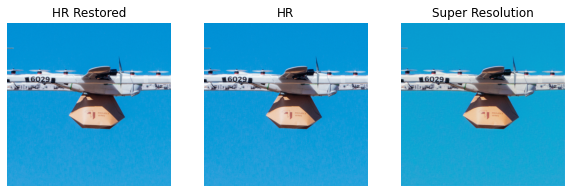

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
show_result(hr, hr_restore, sr, f'{test_img_path}/result.jpg')